<a href="https://colab.research.google.com/github/iopebiel/machine_learning_fraud_credit_card/blob/logisticRegression/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bibliotecas

In [1]:
!pip install imblearn
import pandas as pd
import seaborn as sn
import kagglehub as kh
import os
from sklearn.metrics import roc_auc_score
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, matthews_corrcoef
import matplotlib.pyplot as plt

Download Arquivo CSV no repositório Credit Card Fraud na plataforma Kaggle

In [2]:
path = kh.dataset_download("mlg-ulb/creditcardfraud")

print("Caminho para o Dataset:", path)
os.listdir(path)

Caminho para o Dataset: /kaggle/input/creditcardfraud


['creditcard.csv']

In [3]:
data = pd.read_csv("../kaggle/input/creditcardfraud/creditcard.csv")
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Pré processamento dos dados

In [4]:
number_of_fraud = len(data[data.Class == 1])
number_of_normal= len(data[data.Class == 0])

print ("Fraude:", number_of_fraud)
print ("Legítima:",number_of_normal)

Fraude: 492
Legítima: 284315


In [5]:
X = data.drop("Class", axis=1)
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
counter = Counter(y_train)
print('Base de dados de treino antes do SMOTE:', counter)
counter = Counter(y_test)
print('Base de dados de teste', counter)

Base de dados de treino antes do SMOTE: Counter({0: 199020, 1: 344})
Base de dados de teste Counter({0: 85295, 1: 148})


##SMOTE 50:50

In [6]:
enn = EditedNearestNeighbours()
X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
print('Base de treino depois do ENN:', Counter(y_train_resampled))

smt = SMOTE(random_state=42)
X_train_sm_5050, y_train_sm_5050 = smt.fit_resample(X_train_resampled, y_train_resampled)
counter = Counter(y_train_sm_5050)
print('Depois do SMOTE:', counter)

Base de treino depois do ENN: Counter({0: 198698, 1: 344})
Depois do SMOTE: Counter({0: 198698, 1: 198698})


##SMOTE 10 : 90

In [7]:
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
print('Depois do ENN:', Counter(y_train_enn))

smt = SMOTE(random_state=42, sampling_strategy=0.111)
X_train_sm_1090, y_train_sm_1090 = smt.fit_resample(X_train_enn, y_train_enn)
counter = Counter(y_train_sm_1090)
print('Depois do SMOTE:', counter)

Depois do ENN: Counter({0: 198698, 1: 344})
Depois do SMOTE: Counter({0: 198698, 1: 22055})


#MODELO TREINAMENTO SEM SMOTE

#####**MODELO 1 SCIKIT LEARN PURO**

In [17]:
model = LogisticRegression(solver='saga', max_iter=10000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train,y_train)
y_pred_rl = model.predict(X_train)

print(classification_report(y_train, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.


convergence after 9318 epochs took 1448 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.62      0.10      0.17       344

    accuracy                           1.00    199364
   macro avg       0.81      0.55      0.58    199364
weighted avg       1.00      1.00      1.00    199364



In [18]:
print(X_test)
resultado_rl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SEM SMOTE



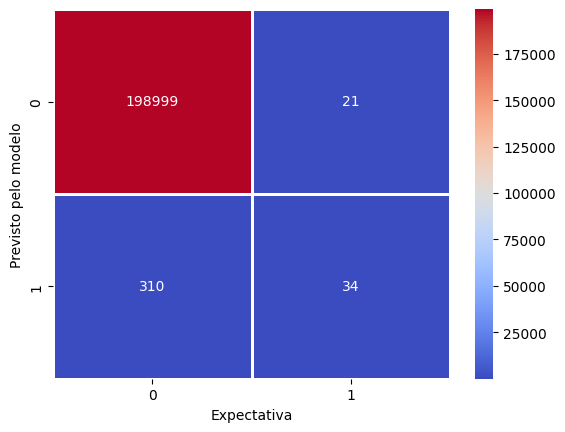

Acurácia: 99.833972%
Precisão: 61.818182%
Recall:  9.883721%
F1 Score:  17.042607%
MCC:  24.673989%

MÉTRICAS TESTE
 
SEM SMOTE



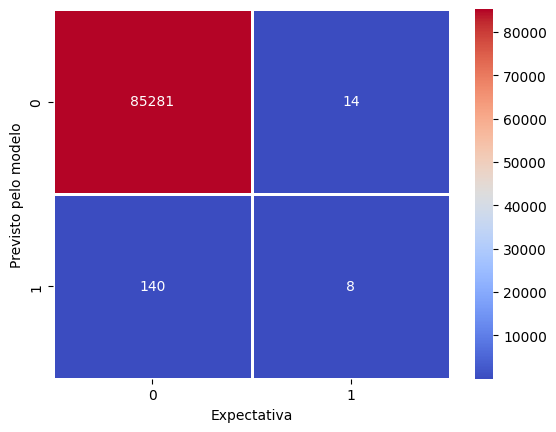

Acurácia: 99.819763%
Precisão: 36.363636%
Recall:  5.405405%
F1 Score:  9.411765%
MCC:  13.967108%

MÉTRICA AUC ROC

Treinamento:  0.5493658461344307 
Teste: 0.5269449589104902


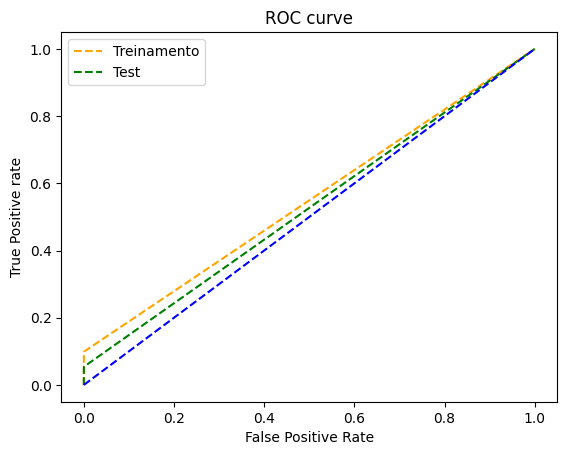

In [19]:
cf_matrix = confusion_matrix(y_train, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train, y_pred_rl):%}')
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#####**MODELO 2 SCIKIT LEARN RAPIDS CUML**

In [8]:
model = cuLogisticRegression(solver='qn', verbose=True)  # qn é equivalente ao saga #Epoch:387
model.fit(X_train, y_train)
y_pred_curl = model.predict(X_train)

print(classification_report(y_train, y_pred_curl))

[2025-08-01 22:23:48.840] [CUML] [debug] Running L-BFGS
[2025-08-01 22:23:49.014] [CUML] [debug] 0000: f(x)=0.69314718 conv.crit=68251.42655423 (gnorm=47308.28388526, fmag=0.69314718)
[2025-08-01 22:23:49.029] [CUML] [debug] 0001: f(x)=0.55107485 conv.crit=255.09836626 (gnorm=140.57829329, fmag=0.55107485)
[2025-08-01 22:23:49.031] [CUML] [debug] 0002: f(x)=0.54944792 conv.crit=255.85112980 (gnorm=140.57687048, fmag=0.54944792)
[2025-08-01 22:23:49.047] [CUML] [debug] 0003: f(x)=0.23218927 conv.crit=600.98019078 (gnorm=139.54115299, fmag=0.23218927)
[2025-08-01 22:23:49.062] [CUML] [debug] 0004: f(x)=0.06763318 conv.crit=1909.79871670 (gnorm=129.16576723, fmag=0.06763318)
[2025-08-01 22:23:49.073] [CUML] [debug] 0005: f(x)=0.03961424 conv.crit=2454.22303714 (gnorm=97.22218686, fmag=0.03961424)
[2025-08-01 22:23:49.080] [CUML] [debug] 0006: f(x)=0.03540752 conv.crit=1983.10836801 (gnorm=70.21695150, fmag=0.03540752)
[2025-08-01 22:23:49.084] [CUML] [debug] 0007: f(x)=0.03489269 conv.cri

In [9]:
print(X_test)
resultado_curl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SEM SMOTE



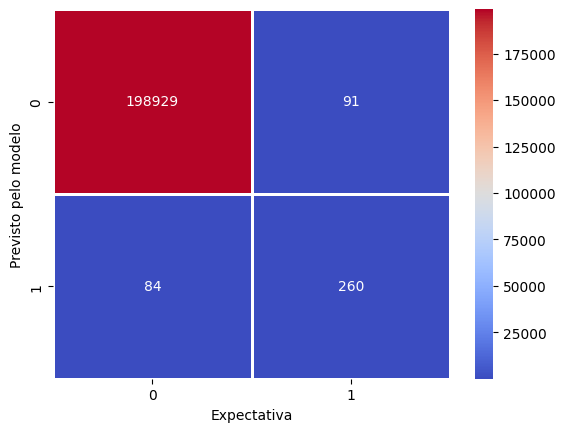

Acurácia: 99.912221%
Precisão: 74.074074%
Recall:  75.581395%
F1 Score:  74.820144%
MCC:  74.779988%

MÉTRICAS TESTE
 
SEM SMOTE



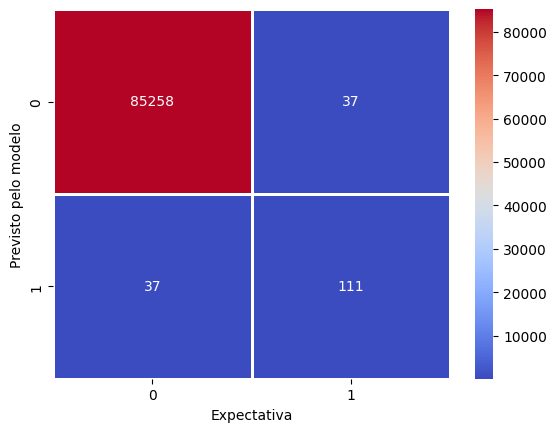

Acurácia: 99.913393%
Precisão: 75.000000%
Recall:  75.000000%
F1 Score:  75.000000%
MCC:  74.956621%

MÉTRICA AUC ROC

Treinamento:  0.8776783565050142 
Teste: 0.87478310569201


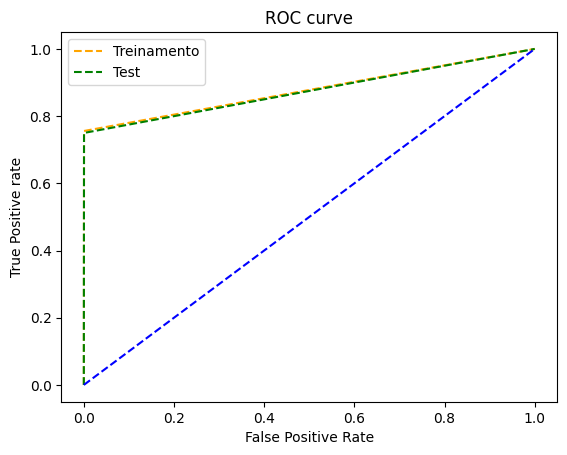

In [10]:
cf_matrix = confusion_matrix(y_train, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train, y_pred_curl):%}')
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#MODELO TREINAMENTO 10 : 90

#####**MODELO 1**

In [20]:
model = LogisticRegression(solver='saga', max_iter=6000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train_sm_1090, y_train_sm_1090)
y_pred_rl = model.predict(X_train_sm_1090)

print(classification_report(y_train_sm_1090, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.


convergence after 5827 epochs took 1015 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    198698
           1       0.91      0.88      0.89     22055

    accuracy                           0.98    220753
   macro avg       0.95      0.94      0.94    220753
weighted avg       0.98      0.98      0.98    220753



In [21]:
print(X_test)
resultado_rl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SMOTE 1090



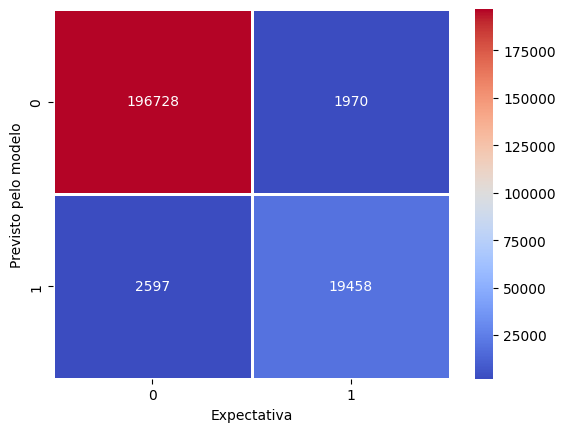

Acurácia: 97.931172%
Precisão: 90.806422%
Recall:  88.224892%
F1 Score:  89.497045%
MCC:  88.361191%

MÉTRICAS TESTE
 
SMOTE 1090



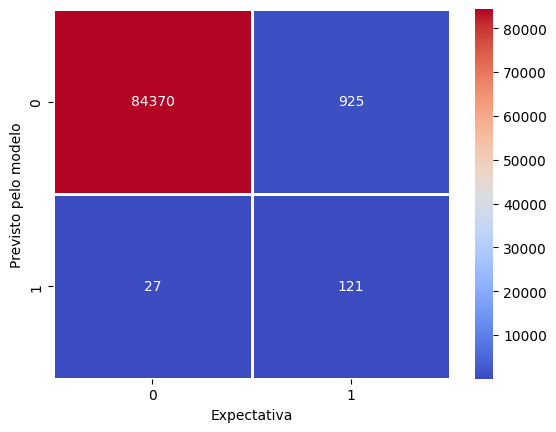

Acurácia: 98.885807%
Precisão: 11.567878%
Recall:  81.756757%
F1 Score:  20.268007%
MCC:  30.506168%

MÉTRICA AUC ROC

Treinamento:  0.9361671897336631 
Teste: 0.9033614260840359


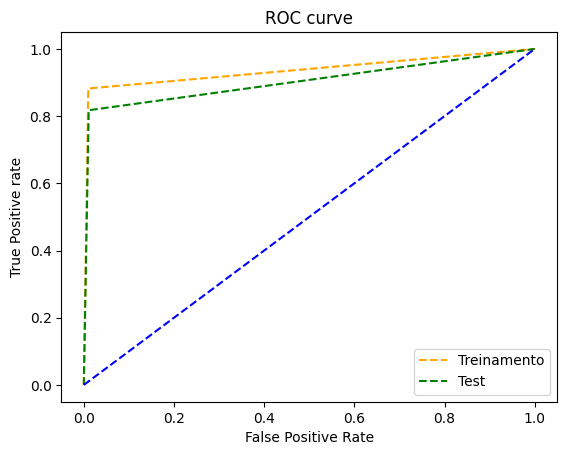

In [22]:
cf_matrix = confusion_matrix(y_train_sm_1090, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_1090, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train_sm_1090, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train_sm_1090, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_1090, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_1090, y_pred_rl):%}')
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_1090, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_1090, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#####**MODELO 2**

In [11]:
model = cuLogisticRegression(solver='qn', verbose=True)  # qn é equivalente ao saga #epochs 120
model.fit(X_train_sm_1090, y_train_sm_1090)
y_pred_curl = model.predict(X_train_sm_1090)

print(classification_report(y_train_sm_1090, y_pred_curl))

[2025-08-01 22:23:51.052] [CUML] [debug] CY::Estimator parameters:
[2025-08-01 22:23:51.056] [CUML] [debug] {'C': 1.0,
 '_input_mem_type': None,
 '_input_type': None,
 '_verbose': 5,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x794704a319b0>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 1000,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::'}
[2025-08-01 22:23:51.096] [CUML] [debug] CY::Setting loss to sigmoid
[2025-08-01 22:23:51.096] [CUML] [debug] CY::Calling QN fit sigmoid
[2025-08-01 22:23:51.098] [CUML] [debug] Running L-BFGS
[2025-08-01 22:23:51.100] [CUML] [debug] 0000: f(x)=0.69314718 conv.crit=55752.59853057 (gnorm=38644.75648035, fmag=0.69314718)
[2025-08-01 22:23:51.114] [CUML] [debug] 0001: f(x)=0.54424994 con

In [12]:
print(X_test)
resultado_curl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SMOTE 1090



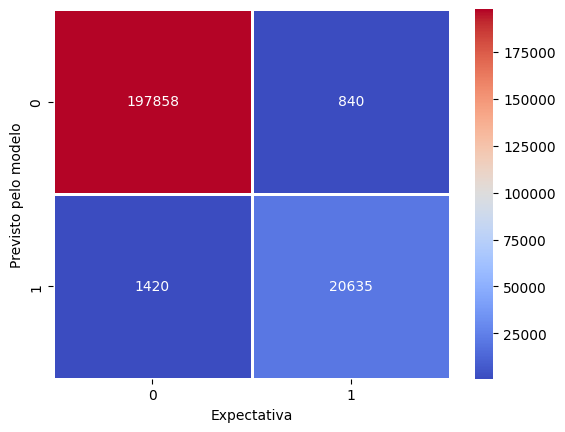

Acurácia: 98.976231%
Precisão: 96.088475%
Recall:  93.561551%
F1 Score:  94.808178%
MCC:  94.250713%

MÉTRICAS TESTE
 
SMOTE 1090



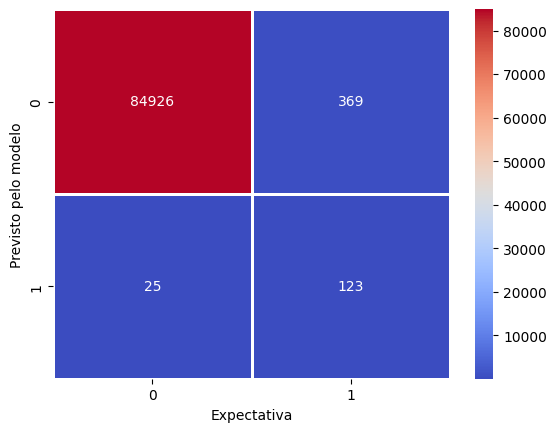

Acurácia: 99.538874%
Precisão: 25.000000%
Recall:  83.108108%
F1 Score:  38.437500%
MCC:  45.436266%

MÉTRICA AUC ROC

Treinamento:  0.9656939927625281 
Teste: 0.9133774594689654


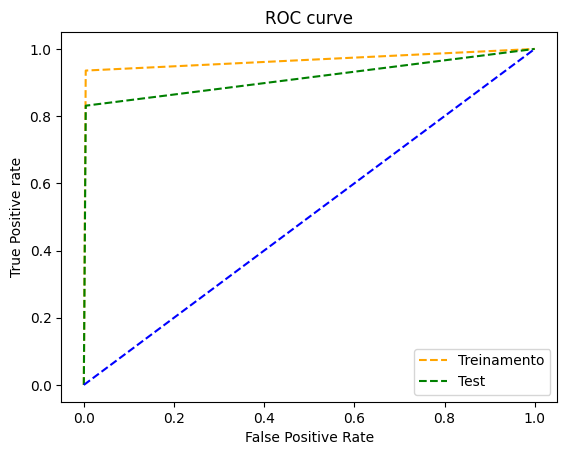

In [13]:
cf_matrix = confusion_matrix(y_train_sm_1090, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_1090, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train_sm_1090, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train_sm_1090, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_1090, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_1090, y_pred_curl):%}')
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_1090, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_1090, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#**MODELOS TREINAMENTO 50:50**

#####**MODELO 1**

In [23]:
model = LogisticRegression(solver='saga', max_iter=6000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train_sm_5050,y_train_sm_5050)
y_pred_rl = model.predict(X_train_sm_5050)

print(classification_report(y_train_sm_5050, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.


convergence after 5343 epochs took 1874 seconds
              precision    recall  f1-score   support

           0       1.00      0.04      0.07    198698
           1       0.51      1.00      0.67    198698

    accuracy                           0.52    397396
   macro avg       0.75      0.52      0.37    397396
weighted avg       0.75      0.52      0.37    397396



In [24]:
print(X_test)
resultado_rl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SMOTE 5050



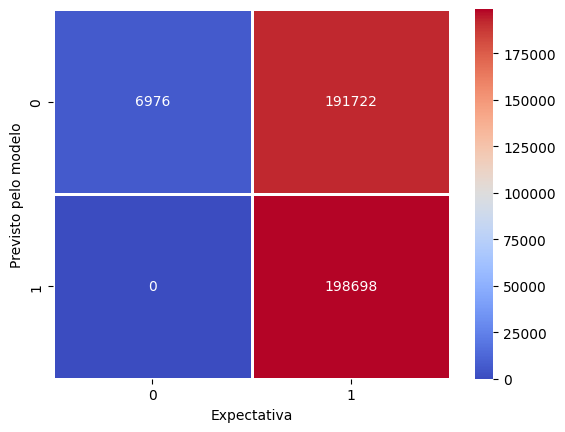

Acurácia: 51.755428%
Precisão: 50.893397%
Recall:  100.000000%
F1 Score:  67.456095%
MCC:  13.367100%

MÉTRICAS TESTE
 
SMOTE 5050



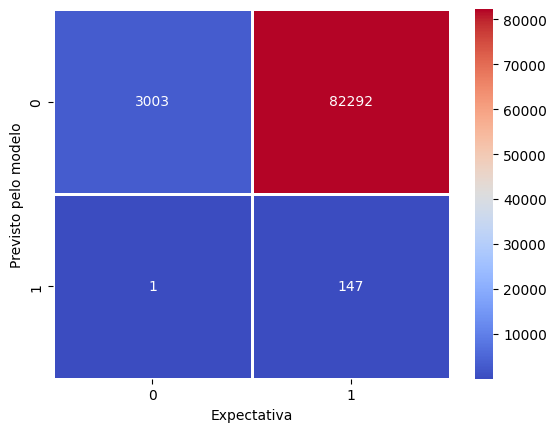

Acurácia: 3.686668%
Precisão: 0.178314%
Recall:  99.324324%
F1 Score:  0.355988%
MCC:  0.642341%

MÉTRICA AUC ROC

Treinamento:  0.5175542783520719 
Teste: 0.5142252326187492


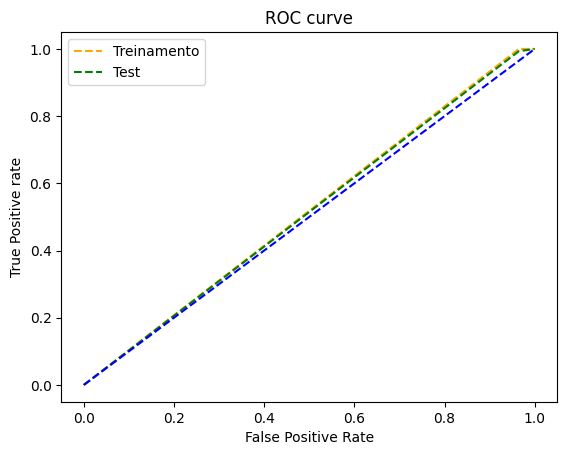

In [25]:
cf_matrix = confusion_matrix(y_train_sm_5050, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 5050\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_5050, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train_sm_5050, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train_sm_5050, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_5050, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_5050, y_pred_rl):%}')
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 5050\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_5050, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_5050, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#####**MODELO 2**

In [14]:
model = cuLogisticRegression(solver='qn', verbose=True)  # qn é equivalente ao saga #epochs=129
model.fit(X_train_sm_5050, y_train_sm_5050)
y_pred_curl = model.predict(X_train_sm_5050)

print(classification_report(y_train_sm_5050, y_pred_curl))

[2025-08-01 22:23:52.824] [CUML] [debug] CY::Estimator parameters:
[2025-08-01 22:23:52.825] [CUML] [debug] {'C': 1.0,
 '_input_mem_type': None,
 '_input_type': None,
 '_verbose': 5,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x794704134c00>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 1000,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::'}
[2025-08-01 22:23:52.958] [CUML] [debug] CY::Setting loss to sigmoid
[2025-08-01 22:23:52.958] [CUML] [debug] CY::Calling QN fit sigmoid
[2025-08-01 22:23:53.073] [CUML] [debug] Running L-BFGS
[2025-08-01 22:23:53.075] [CUML] [debug] 0000: f(x)=0.69314718 conv.crit=4782.10506551 (gnorm=3314.70264330, fmag=0.69314718)
[2025-08-01 22:23:53.109] [CUML] [debug] 0001: f(x)=0.69140429 conv.

In [15]:
print(X_test)
resultado_curl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SMOTE 1090



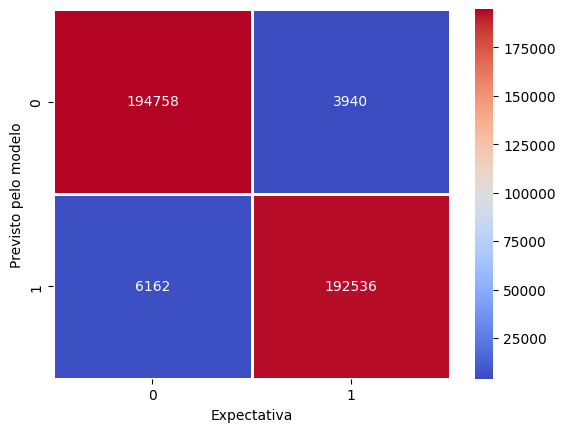

Acurácia: 97.457951%
Precisão: 97.994666%
Recall:  96.898811%
F1 Score:  97.443658%
MCC:  94.921838%

MÉTRICAS TESTE
 
SMOTE 5050



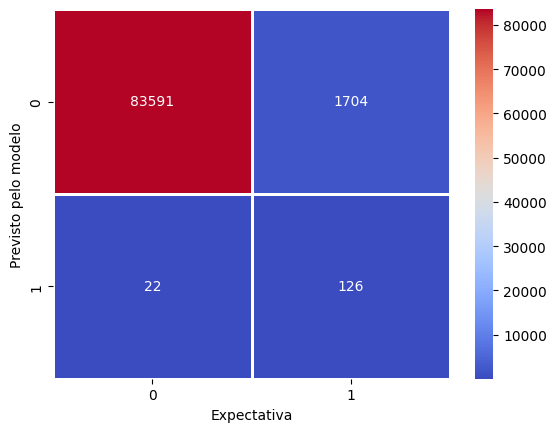

Acurácia: 97.979940%
Precisão: 6.885246%
Recall:  85.135135%
F1 Score:  12.740142%
MCC:  23.879567%

MÉTRICA AUC ROC

Treinamento:  0.974579512627203 
Teste: 0.9156868134914913


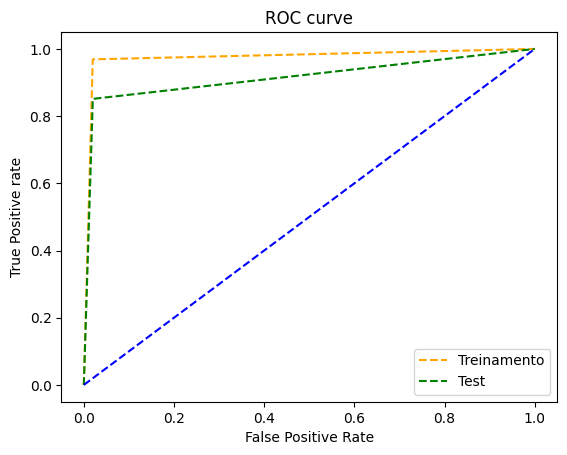

In [16]:
cf_matrix = confusion_matrix(y_train_sm_5050, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_5050, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train_sm_5050, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train_sm_5050, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_5050, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_5050, y_pred_curl):%}')
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 5050\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_5050, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_5050, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();